In [1]:
import sys
import pandas as pd
from Bio import SeqIO
from Bio import SearchIO
import os
import glob
from pathlib import Path
from Bio import AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import pybedtools  

In [2]:
#Read methylation data 
os.chdir('../../data/Methylation/')
bed_5mC = pd.read_table('Au3_5mCpG_filtered.bed', header=None)
bed_5mC.columns = ['chr', 'start', 'end', 'score','reads_count']


In [3]:
Au3_genome_hapA = list(SeqIO.parse('../Au3_CHR_hapA_v3.fasta', 'fasta'))
Au3_genome_hapB = list(SeqIO.parse('../Au3_CHR_hapB_v3.fasta', 'fasta'))
Au3_genome = Au3_genome_hapA + Au3_genome_hapB

In [4]:
Au3_genome_renamed = []
for seq in Au3_genome:
    seqid_old = seq.id
    seq_seq = seq.seq
    if '_ab' in seq.id:
        seqnew = 'Chr14B'
    elif 'HapA' in seqid_old:
        #Add A to the end of the chromosome name
        seqnew = seq.id + 'A'
        seqnew = seqnew.replace('APSI_AU3_HapA_CHR', 'Chr')
    elif 'HapB' in seqid_old:
        #Add B to the end of the chromosome name
        seqnew = seq.id + 'B'
        seqnew = seqnew.replace('APSI_AU3_HapB_CHR', 'Chr')
    Au3_genome_renamed.append(SeqRecord(seq=seq_seq, id=seqnew, name=seqid_old, description=''))


In [5]:
gene_annotation = pd.read_table('../Au3_deduplicate/Au3_deduplicate.gff3', header=None, sep='\t')

In [6]:
effecotr_list = pd.read_table('../Effector/secretome.list', header=None, sep='\t')

In [7]:
effecotr_list.columns = ['gene_id']

In [8]:
gene_annotation = gene_annotation[gene_annotation[2] == 'CDS']
gene_annotation = gene_annotation.reset_index(drop=True)
gene_annotation.columns = ['chr', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
gene_annotation['attributes'] = gene_annotation['attributes'].str.split(';').str[0].str.split('ID=').str[1]
gene_annotation_renamed = gene_annotation.copy()

for seqid in Au3_genome_renamed:
    old_name = seqid.name
    old_name = old_name.replace('APSI_', '')
    new_name = seqid.id
    gene_annotation_renamed['chr'] = gene_annotation_renamed['chr'].str.replace(old_name, new_name)

gene_annotation_renamed['chr'] = gene_annotation_renamed['chr'].str.replace('Chr14Aab', 'Chr14B')

In [9]:
gene_annotation_renamed['gene_id'] = gene_annotation_renamed['attributes'].str.split('.cds').str[0]
gene_annotation_cds = gene_annotation_renamed.copy()
#group by gene_id and get the min and max of the start and end
gene_annotation_cds = gene_annotation_cds.groupby('gene_id').agg({'chr':'first', 'start':'min', 'end':'max', 'strand':'first'}).reset_index()

In [10]:
gene_annotation_cds_list = gene_annotation_cds['gene_id'].tolist()

In [11]:
effector_list_cds = []
no_effector_list_cds = []
for gene in gene_annotation_cds_list:
    tmp = gene.split('-')[0]
    if tmp in effecotr_list['gene_id'].tolist():
        effector_list_cds.append(gene)
    else:
        no_effector_list_cds.append(gene)

In [12]:
effector_list_cds_df = gene_annotation_cds[gene_annotation_cds['gene_id'].isin(effector_list_cds)]

In [13]:
no_effector_list_cds_df = gene_annotation_cds[gene_annotation_cds['gene_id'].isin(no_effector_list_cds)]

In [14]:
effector_list_cds_df_flanking_seq_upstream = []
for index, row in effector_list_cds_df.iterrows():
    seq = [seq for seq in Au3_genome_renamed if seq.id == row['chr']][0]
    seq_seq = seq.seq
    #If strand is positive
    if row['strand'] == '+':
        start = row['start']- 1000 -2
        end = row['end'] -2
        seq_seq = seq_seq[start:end]
    else:
        start = row['end']+ 1000 
        end = row['end'] 
        seq_seq = seq_seq[row['start']:row['end']].reverse_complement()
    effector_list_cds_df_flanking_seq_upstream.append(SeqRecord(seq=seq_seq, id=row['gene_id'], description=''))

no_effector_list_cds_df_flanking_seq_upstream = []
for index, row in no_effector_list_cds_df.iterrows():
    seq = [seq for seq in Au3_genome_renamed if seq.id == row['chr']][0]
    seq_seq = seq.seq
    #If strand is positive
    if row['strand'] == '+':
        start = row['start']- 1000 -2
        end = row['end'] -2
        seq_seq = seq_seq[start:end]
    else:
        start = row['end']+ 1000 
        end = row['end'] 
        seq_seq = seq_seq[row['start']:row['end']].reverse_complement()
    no_effector_list_cds_df_flanking_seq_upstream.append(SeqRecord(seq=seq_seq, id=row['gene_id'], description=''))

In [15]:
effector_df = effector_list_cds_df.copy()
effector_df['effector'] = 'Yes'
effector_df_tmp = no_effector_list_cds_df.copy()
effector_df_tmp['effector'] = 'No'
effector_df = pd.concat([effector_df, effector_df_tmp]).sort_values(['chr', 'start'])
#Get upstream 1kb position
effector_df['upstream_start'] = effector_df.apply(lambda x: x['start'] - 1002 if x['strand'] == '+' else x['end'], axis=1)
effector_df['upstream_end'] = effector_df.apply(lambda x: x['end'] - 2 if x['strand'] == '+' else x['end'] + 1000, axis=1)
effector_df['downstream_start'] = effector_df.apply(lambda x: x['end'] + 1 if x['strand'] == '+' else x['start'] - 1001, axis=1)
effector_df['downstream_end'] = effector_df.apply(lambda x: x['end'] + 1001 if x['strand'] == '+' else x['start'] -1, axis=1)

In [16]:
effector_df['id'] = effector_df['gene_id'].str.split('-').str[0]
# Calculate the length of each gene
effector_df['length'] = effector_df['end'] - effector_df['start']
# If the id is the same, only keep the longest one
effector_df = effector_df.sort_values(['id', 'length'], ascending=False).drop_duplicates('id', keep='first')

In [30]:
effector_df_upstream_bed = effector_df[['chr', 'upstream_start', 'upstream_end']]
effector_df_downstream_bed = effector_df[['chr', 'downstream_start', 'downstream_end']]


In [31]:
effector_df_upstream_bed = pybedtools.BedTool.from_dataframe(effector_df_upstream_bed)
effector_df_downstream_bed = pybedtools.BedTool.from_dataframe(effector_df_downstream_bed)

In [32]:
bed_5mCpG = bed_5mC[['chr', 'start', 'end']]
bed_5mCpG = pybedtools.BedTool.from_dataframe(bed_5mCpG)

In [33]:
#Get intersection with 5mC sites
effector_df_upstream_bed_5mC = effector_df_upstream_bed.intersect(bed_5mCpG, wa=True, wb=True)
effector_df_downstream_bed_5mC = effector_df_downstream_bed.intersect(bed_5mCpG, wa=True, wb=True)


***** WARNING: File /tmp/pybedtools.yyni3yi1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512

***** WARNING: File /tmp/pybedtools.yyni3yi1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512

***** WARNING: File /tmp/pybedtools.yyni3yi1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512

***** WARNING: File /tmp/pybedtools.yyni3yi1.tmp has a record where naming convention (leading zero) is inconsistent with other files:
Chr10A	13511	13512



In [34]:
effector_df_upstream_bed_5mC = effector_df_upstream_bed_5mC.to_dataframe()
effector_df_downstream_bed_5mC = effector_df_downstream_bed_5mC.to_dataframe()
#sort by chrom and start, end, get the sum of 5mC sites
effector_df_upstream_bed_5mC = effector_df_upstream_bed_5mC.sort_values(['chrom', 'start', 'end']).groupby(['chrom', 'start', 'end']).size().reset_index()
effector_df_downstream_bed_5mC = effector_df_downstream_bed_5mC.sort_values(['chrom', 'start', 'end']).groupby(['chrom', 'start', 'end']).size().reset_index()

In [46]:
effector_df_upstream_bed_5mC.columns = ['chr', 'start', 'end', '5mC_count']
#Merge with effector_df_upstream_bed
effector_df_tmp = effector_df[['gene_id', 'chr', 'upstream_start', 'upstream_end', 'strand', 'effector']]
effector_df_tmp.columns = ['gene_id', 'chr', 'start', 'end', 'strand', 'effector']  #<-note this start and end is the upstream start and end

#effector_df_upstream_bed = effector_df_upstream_bed.to_dataframe()
effector_df_upstream_bed = effector_df_tmp.merge(effector_df_upstream_bed_5mC, on=['chr', 'start', 'end'], how='left')
#fill na with 0
effector_df_upstream_bed['5mC_count'] = effector_df_upstream_bed['5mC_count'].fillna(0)

#Merge with effector_df_downstream_bed
effector_df_downstream_bed_5mC.columns = ['chr', 'start', 'end', '5mC_count']
#effector_df_downstream_bed = effector_df_downstream_bed.to_dataframe()
effector_df_tmp = effector_df[['gene_id', 'chr', 'downstream_start', 'downstream_end', 'strand', 'effector']]
effector_df_tmp.columns = ['gene_id', 'chr', 'start', 'end', 'strand', 'effector']  #<-note this start and end is the downstream start and end

effector_df_downstream_bed = effector_df_tmp.merge(effector_df_downstream_bed_5mC, on=['chr', 'start', 'end'], how='left')
#fill na with 0
effector_df_downstream_bed['5mC_count'] = effector_df_downstream_bed['5mC_count'].fillna(0)

In [108]:
bed_5mCpG = bed_5mC[['chr', 'start', 'end']]
bed_5mCpG = pybedtools.BedTool.from_dataframe(bed_5mCpG)


In [39]:
effector_df_tmp = effector_df[['gene_id', 'chr', 'upstream_start', 'upstream_end', 'strand', 'effector']]
effector_df_tmp.columns = ['gene_id', 'chr', 'start', 'end', 'strand', 'effector'] 

In [47]:
effector_df_upstream_bed

,gene_id,chr,start,end,strand,effector,5mC_count
0,MK676_026288-T1,Chr18A,15728115,15729903,+,No,0.0
1,MK676_026287-T1,Chr18A,14502119,14503442,+,No,0.0
2,MK676_026286-T1,Chr17A,25052808,25054425,+,No,1.0
3,MK676_026285-T3,Chr17A,18836050,18837050,-,No,18.0
4,MK676_026284-T1,Chr17A,9983107,9984661,+,No,0.0
...,...,...,...,...,...,...,...
35567,MK675_000005-T1,Chr01B,392045,393233,+,No,2.0
35568,MK675_000004-T1,Chr01B,287348,288348,-,No,0.0
35569,MK675_000003-T1,Chr01B,282760,285056,+,No,1.0
35570,MK675_000002-T1,Chr01B,280927,282822,+,No,0.0


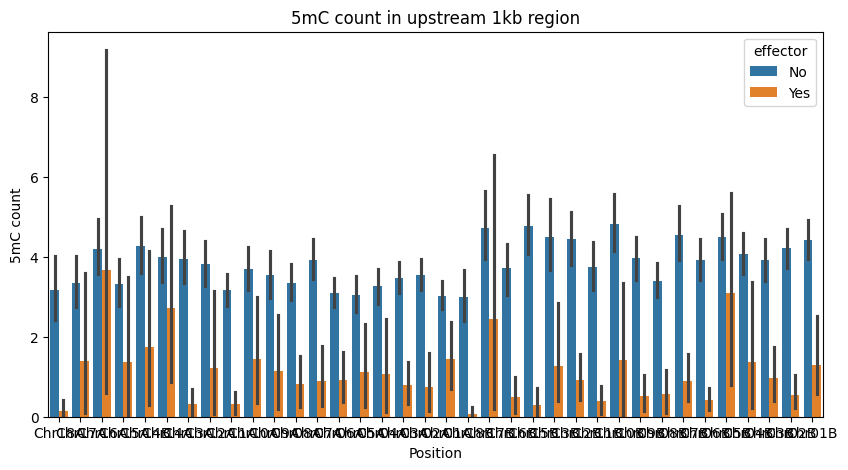

In [51]:
#Plot the 5mC sites for effector is yes with effector_df_upstream_bed
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='chr', y='5mC_count', data=effector_df_upstream_bed, hue='effector', ax=ax)
plt.xlabel('Position')
plt.ylabel('5mC count')
plt.title('5mC count in upstream 1kb region')
plt.show()

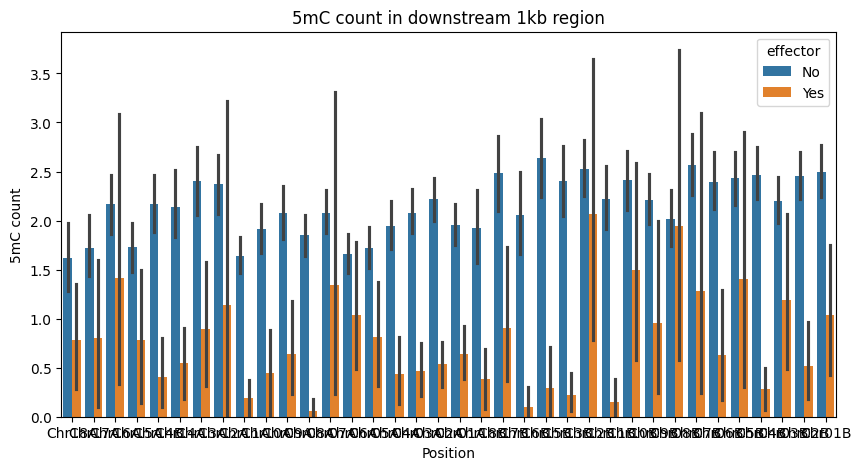

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='chr', y='5mC_count', data=effector_df_downstream_bed, hue='effector', ax=ax)
plt.xlabel('Position')
plt.ylabel('5mC count')
plt.title('5mC count in downstream 1kb region')
plt.show()

In [42]:
effector_df_tmp.merge(effector_df_upstream_bed_5mC, on=['chr', 'start', 'end'], how='left')

,gene_id,chr,start,end,strand,effector,5mC_count
0,MK676_026288-T1,Chr18A,15728115,15729903,+,No,NaN
1,MK676_026287-T1,Chr18A,14502119,14503442,+,No,NaN
2,MK676_026286-T1,Chr17A,25052808,25054425,+,No,1.0
3,MK676_026285-T3,Chr17A,18836050,18837050,-,No,18.0
4,MK676_026284-T1,Chr17A,9983107,9984661,+,No,NaN
...,...,...,...,...,...,...,...
35567,MK675_000005-T1,Chr01B,392045,393233,+,No,2.0
35568,MK675_000004-T1,Chr01B,287348,288348,-,No,NaN
35569,MK675_000003-T1,Chr01B,282760,285056,+,No,1.0
35570,MK675_000002-T1,Chr01B,280927,282822,+,No,NaN


In [38]:
effector_df_upstream_bed_5mC

,chr,start,end,5mC_count
0,Chr01A,130870,131870,2
1,Chr01A,195429,196429,2
2,Chr01A,314743,317039,2
3,Chr01A,545842,546842,4
4,Chr01A,555386,556386,2
...,...,...,...,...
19516,Chr18B,25755626,25757296,6
19517,Chr18B,25767499,25769319,3
19518,Chr18B,26054617,26055617,11
19519,Chr18B,26383376,26385960,8


In [102]:
test_chr1B[12446:12448].reverse_complement()

SeqRecord(seq=Seq('CG'), id='<unknown id>', name='<unknown name>', description='<unknown description>', dbxrefs=[])

In [47]:
test_chr1B = next((seq for seq in Au3_genome_renamed if seq.id == 'Chr01B'), None)

In [104]:
test_chr1B.seq[14157:14159]

Seq('CG')

In [81]:
print(test_chr1B.seq[8736713:8736713+1000].reverse_complement())

AAATAAAACTTGGTTTTTTTAGTTTGGATTGTGATGAAAAAATATTTCAAATTTGTTTTCCAAAGCTCGTTGAGAAACGTGGCCTAAGTTTTTCTCCTCAAACTTCTCAAAGAGTAACAAGGTATCTTAAGTGCAAAAGGGAGTCGCGCAAAATCATGCTTCACTCAAGGCGAATCCTTTAGTAATGCTACAGGGAGAGATACTTTCACTCACCGAATACTTAAATGCGAGGATTTCAAACTGGAACATTTTTCTCGTACAGTACAGGCTTTGTCATACAGCTGTATTGGACAAAGAAGGTTTCACTTTTTCCCAGGTTTTTTTAGGTATGGAGAGGGAATATTGGGCGTTGATCTTCTCAAAACAGTCGTGTGCTTCACTATCACTCCTTCAGTAACATCTACAGGGAAAGAGATGCTTTTATTGGCTCATTACTTAAAATGCGAGGATACAAAATTAAAGCACGTCTTTCCTAAAGGCTCTCCAATGAGCCTTGGACGGGCACATTTTGCCTTGTCGTAGGTTTTGTTAGGTGTCGAGATACAATATTGAGGGTTGCTTGTTTCAAAATACTTGCGGAGGGCAGAGAAATTTTTTCATTTTCTGTGAAAGCTTGCGCTGTAGTCAACCTCATTTTTCATACCATCCCACATTGAGAGTAGCCTTCATCGCTGGTTGCTCCAGAAAGGGACCTCTCGATCCCTTAGCAAGGACAGGGACCAATAATATGCCGAAGAAGTTTTTACACTGTATTGGGCAGGAGGCGCATGCCCCTTCAGCGAGGTTTTTCCGCTCTTTGACCATGTTGGCTTTTTCCACCCATTGGGAAGGAAAGTCTGCAAGTCTTCCCAAGCATTAGAGAAAACCATTACGAATGATTGAGGCCTATAAGGCTCTGCTAGTTTGAAGGGTTGTTTGAAGTATATCCCACTATTCGACGGACGCCACCCCATCATTTTTTGTTTTACATTGTTCCATACGGCAATCCGCTTAATGATCG